In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize

# cosamp function is available at https://github.com/avirmaux/CoSaMP

plt.rcParams['figure.figsize'] = [25, 4]
plt.rcParams.update({'font.size': 18})

In [2]:
import librosa

## Loading the audio signal

In [3]:
file_path = '../../data/rawSampleAudios/Voice 002.m4a'
audio_data, sample_rate = librosa.load(file_path)

print(f"Audio data: {audio_data}")
print(f"Sample rate: {sample_rate}")

/tmp/ipykernel_275242/3215823874.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path)
/home/jovyan/my-conda-envs/V2Phys215Project/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio data: [ 9.3132257e-10 -2.5611371e-09  1.8626451e-09 ... -1.0505662e-01
 -8.7623805e-02 -8.3545819e-02]
Sample rate: 22050


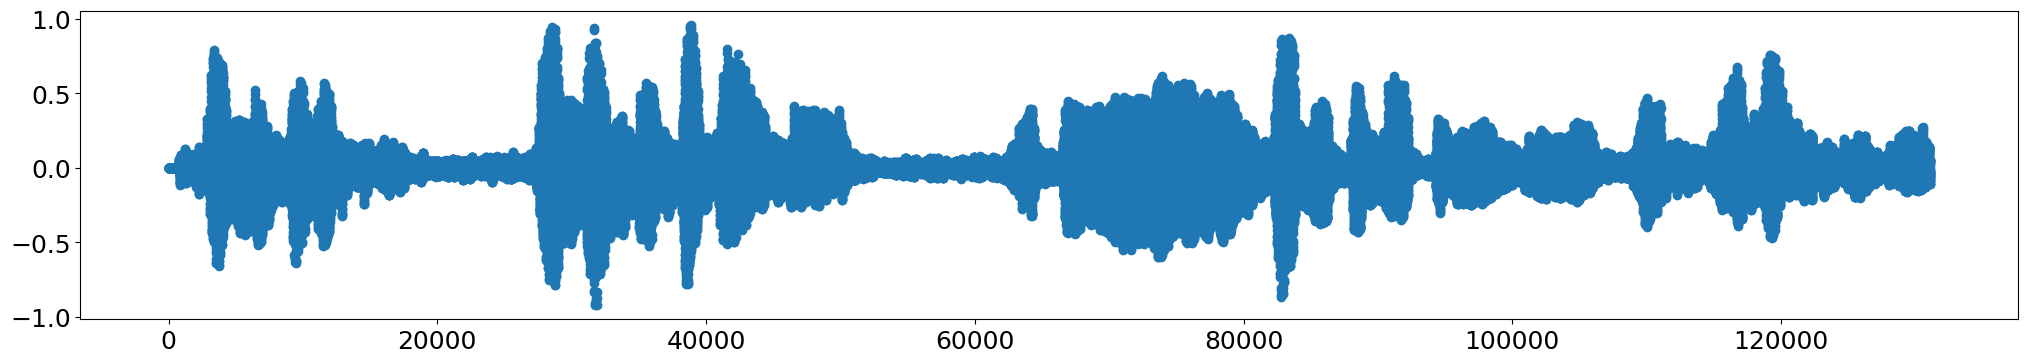

In [4]:
plt.scatter(np.arange(audio_data.size), audio_data)

## Getting the Fourier Transform

In [5]:
np.abs(np.fft.fftshift(np.fft.fft(audio_data)))

array([0.03999657, 0.03998961, 0.0399897 , ..., 0.03998846, 0.0399897 ,
       0.03998961], dtype=float32)

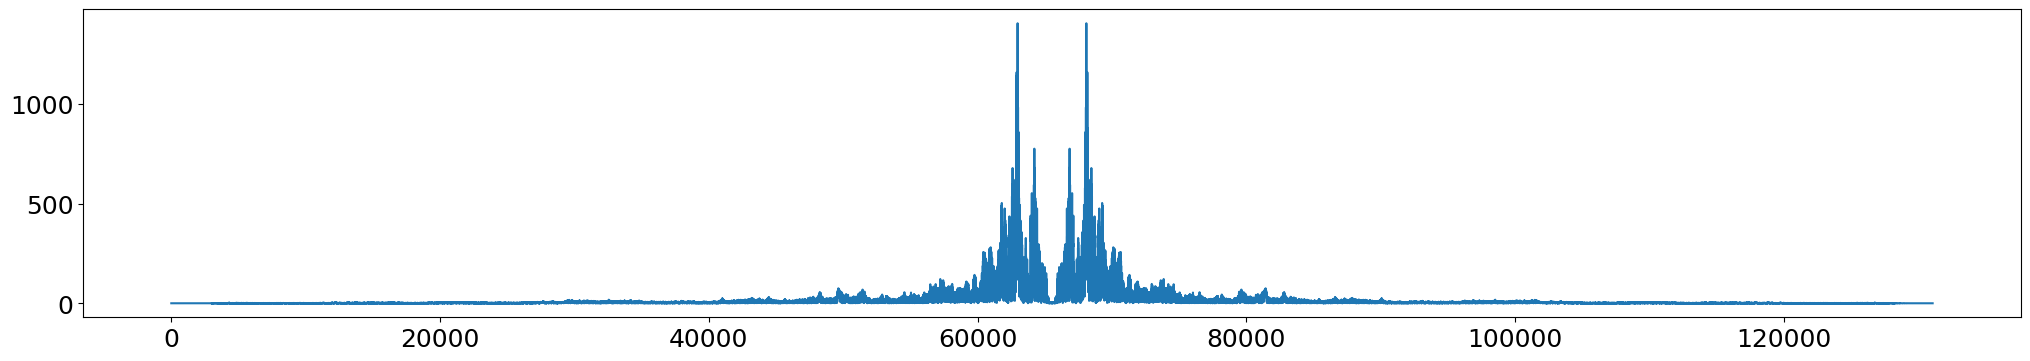

In [6]:
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(audio_data))))

## Low pass filter onto audio

In [7]:
import numpy as np
from numpy.fft import fft, ifft

# Load the audio file
audio_data, sample_rate = librosa.load(file_path)

# Apply FFT
audio_fft = fft(audio_data)

# Design a low-pass filter (example)
cutoff_frequency_h= 2000  # Hz
cutoff_frequency_l = 50 #Hz
filterCond = (np.abs(np.fft.fftfreq(len(audio_data), 1 / sample_rate)) < cutoff_frequency_h) & \
(np.abs(np.fft.fftfreq(len(audio_data), 1 / sample_rate)) > cutoff_frequency_l)
# Apply the filter
filtered_fft = audio_fft * filterCond

# Apply inverse FFT
filtered_audio = ifft(filtered_fft)

# Normalize the audio data to prevent clipping
filtered_audio = np.int16(filtered_audio.real / np.max(np.abs(filtered_audio.real)) * 32767)


/tmp/ipykernel_275242/1176946783.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path)
/home/jovyan/my-conda-envs/V2Phys215Project/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [8]:
audio_data.size

131072

In [9]:
filtered_audio.size

131072

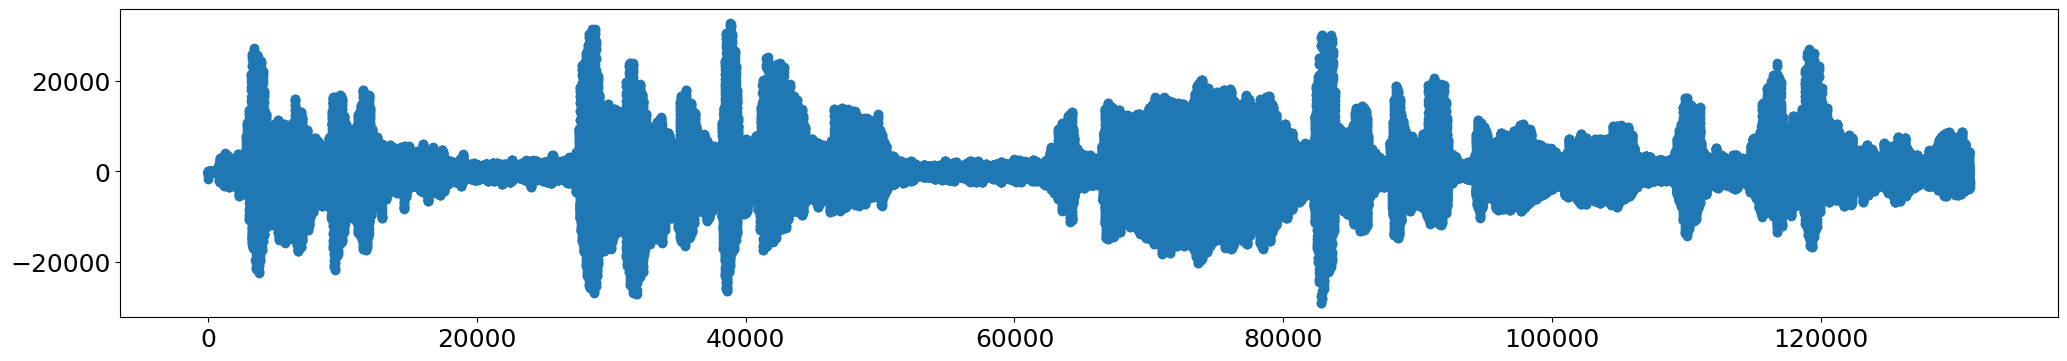

In [10]:
plt.scatter(np.arange(filtered_audio.size), filtered_audio)

## Reconstruction 

### Get subsection of audio

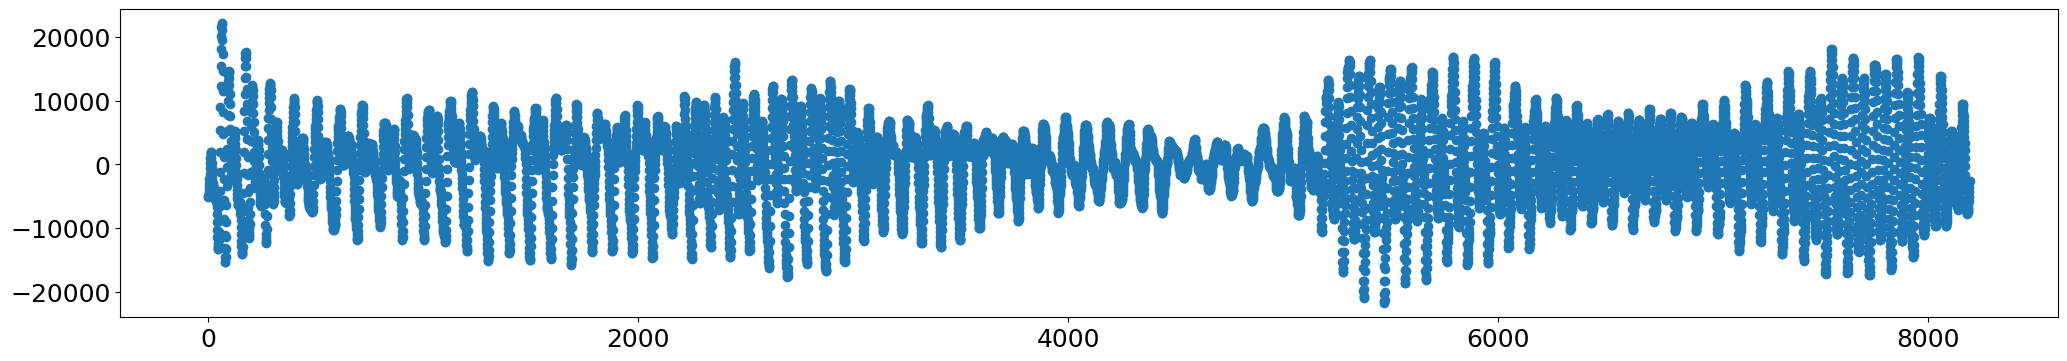

In [11]:
range = (4000, 12192)

subsection_filtered_audio = filtered_audio[range[0]:range[-1]] - np.mean(filtered_audio[range[0]:range[-1]])
plt.scatter(np.arange(subsection_filtered_audio.size), subsection_filtered_audio)

### Actual Reconstruction

In [12]:
sys.path.append(os.path.join('../..'))

from physics215ProjectCode import cosamp_fn as cf
from physics215ProjectCode import constructionSynthetic as cS

In [13]:
p = range[1] - range[0]
subsecFilterAudio_recon, PSD_sFAr, perm_sFAr = cf.reconstructSignal_dct(subsection_filtered_audio, p)

Iteration 3

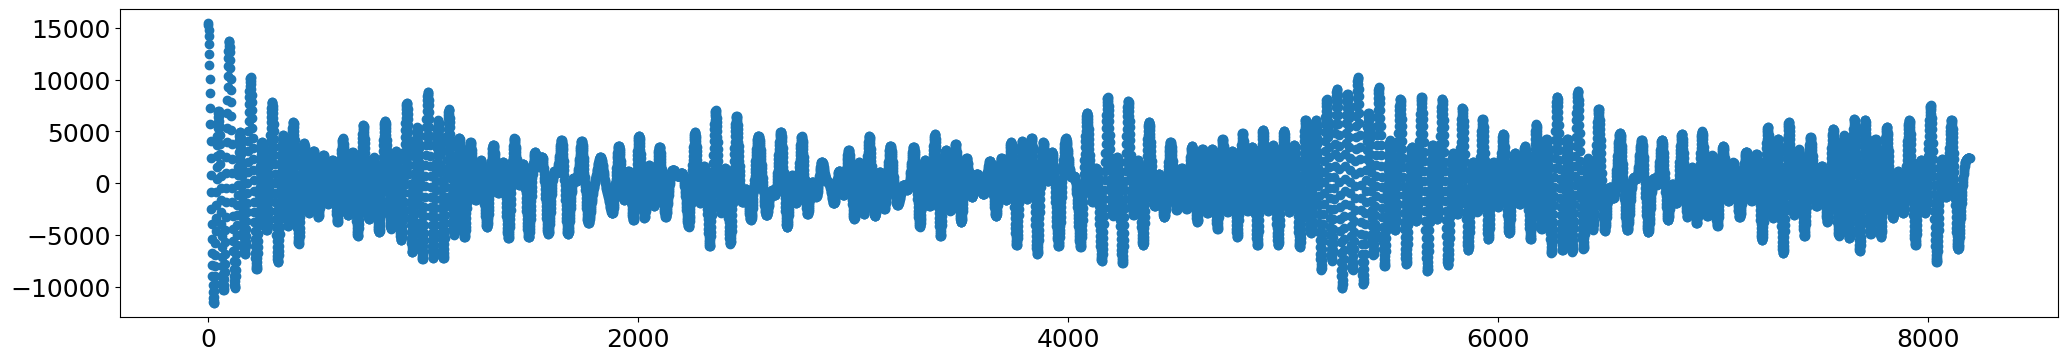

In [14]:
plt.scatter(np.arange(subsecFilterAudio_recon.size), subsecFilterAudio_recon)

### PSD of both the original signal and the reconstructed, comparison by RMSE

In [15]:
from physics215ProjectCode import comparison

In [16]:
#RMSE

ground = np.zeros_like(subsection_filtered_audio, dtype=float)
comparison.rmse(subsection_filtered_audio, subsecFilterAudio_recon)/comparison.rmse(subsection_filtered_audio, ground)

np.float64(0.8551491929603396)

In [17]:
cS.getPSD(subsection_filtered_audio)

array([      0.        +0.00000000e+00j, 1916341.25661614-6.96201055e-15j,
       1916667.09273538-3.97612828e-13j, ...,
       1915623.91729285+8.73380763e-13j, 1916667.09273538+2.94109294e-13j,
       1916341.25661614+2.34588854e-14j])

In [18]:
cS.getPSD(subsecFilterAudio_recon)

array([1.03397577e-25+0.00000000e+00j, 4.97287668e+01-4.09196800e-19j,
       1.98960025e+02+9.22914685e-18j, ...,
       4.47828723e+02-5.27612791e-17j, 1.98960025e+02+4.08297842e-18j,
       4.97287668e+01-1.37680443e-18j])

In [19]:
np.mean(subsection_filtered_audio)

np.float64(0.0)

In [20]:
np.mean(subsecFilterAudio_recon)

np.float64(9.769962616701378e-15)